# FEAST 

Instead of using feature_store.yaml and feast CLI, use SDK.


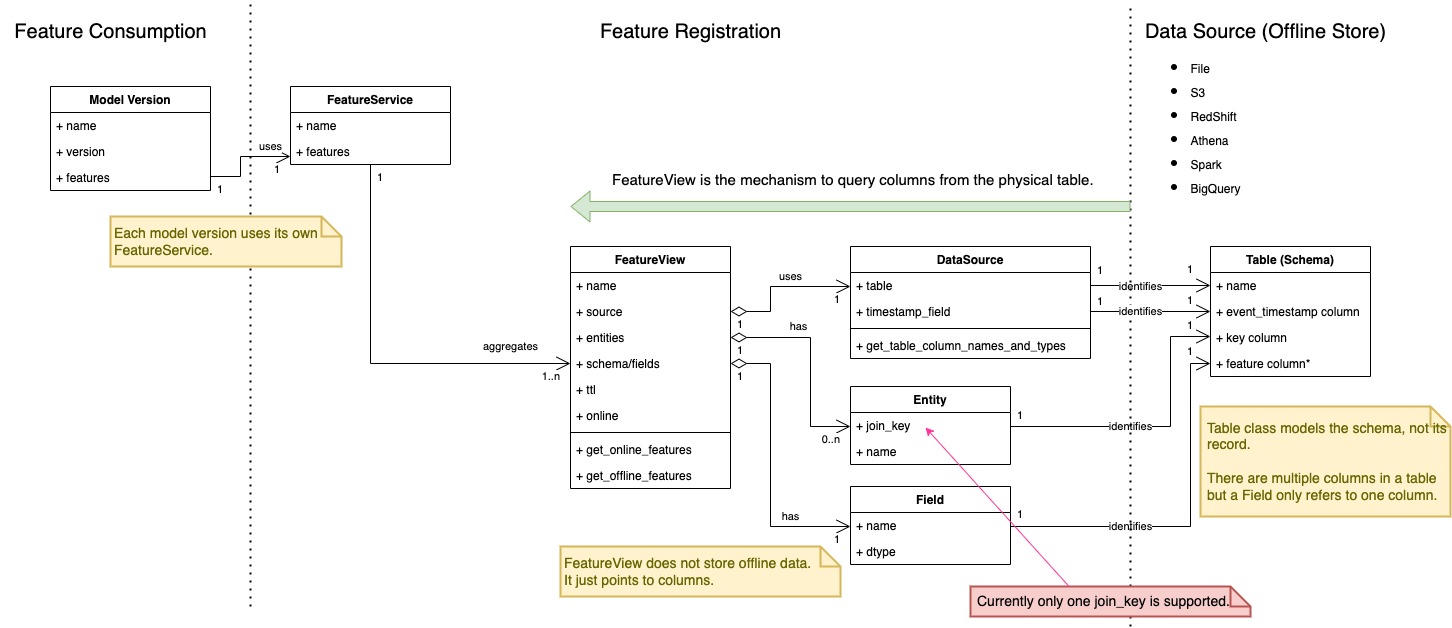

# Setup

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
import os
import sys
import subprocess
from datetime import (
    datetime,
    timedelta
)

import pandas as pd
from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource,
    Project,
    PushSource,
    RequestSource,
    RepoConfig,
)
from feast.repo_config import (
    RegistryConfig
)
from feast.infra.registry.sql import (
    SqlRegistryConfig
)
from feast.feature_logging import LoggingConfig
from feast.infra.offline_stores.file_source import FileLoggingDestination
from feast.infra.online_stores.sqlite import (
    SqliteOnlineStoreConfig
)
from feast.infra.offline_stores.contrib.postgres_offline_store.postgres import (
    PostgreSQLOfflineStoreConfig
)
from feast.on_demand_feature_view import on_demand_feature_view
from feast.types import (
    Float32, Float64, Int64
)
from feast.value_type import (
    ValueType
)
from feast import FeatureStore
from feast.data_source import PushMode

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
pythonpath = os.path.abspath(
    os.path.join(os.getcwd(), '..', 'deployment/feast/feature_repository')
)
if pythonpath not in sys.path:
    sys.path.append(pythonpath)

In [5]:
%load_ext autoreload
%autoreload 2

from psql import (
    batch_insert_with_progress,
    exists_table,
    get_all_tables,
    truncate,
    select_one,
    get_password_from_pgpass,
)
from utility import (
    read_yaml
)

In [6]:
NOTEBOOK_DIR: str = os.getcwd()
FEATURE_REPO_DIR: str = os.path.abspath(os.sep.join(
    [NOTEBOOK_DIR, "../deployment/feast/feature_repository"]
))

--- 
# FEAST Project

In [7]:
feature_store_config = read_yaml(f"{FEATURE_REPO_DIR}/feature_store.yaml")
repo_config = RepoConfig(
    registry=SqlRegistryConfig(
        path="postgresql+psycopg2://postgres@localhost:5432/feast_registry", 
        registry_type="sql",
        sqlalchemy_config_kwargs={
            "echo": False,
            "pool_pre_ping": True,
        }
    ),
    project="customer_credit_risk",
    provider="local",
    offline_store=PostgreSQLOfflineStoreConfig(**feature_store_config['offline_store']),
    online_store=SqliteOnlineStoreConfig(path=f'{FEATURE_REPO_DIR}/data/online_store.db')
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [8]:
feature_store = FeatureStore(config=repo_config)

## Result

In [23]:
for project in feature_store.list_projects():
    print(project)

for fv in feature_store.list_feature_views():
    print(f"FeatureView: {fv.name}")
    for feature in fv.features:
        print(f"  Feature: {feature.name} ({feature.dtype})")

for fs in feature_store.list_feature_services():
    print(f"\nFeatureService: {fs.name}")
    for projection in fs.feature_view_projections:
        print(f"  FeatureProjection: {projection.name}")
        for feature in projection.features:
            print(f"    Feature: {feature.name} ({feature.dtype})")

{
  "spec": {
    "name": "customer_credit_risk",
    "description": "A project for customer credit risk"
  },
  "meta": {
    "createdTimestamp": "2025-09-10T02:36:27.540674Z",
    "lastUpdatedTimestamp": "2025-09-10T07:19:22.520531Z"
  }
}
FeatureView: customer_credit_risk_feature_view
  Feature: purpose_business (Float32)
  Feature: purpose_car (Float32)
  Feature: purpose_domestic_appliances (Float32)
  Feature: purpose_education (Float32)
  Feature: purpose_furniture_equipment (Float32)
  Feature: purpose_radio_tv (Float32)
  Feature: purpose_repairs (Float32)
  Feature: purpose_vacation_others (Float32)
  Feature: gender_female (Float32)
  Feature: gender_male (Float32)
  Feature: property_free (Float32)
  Feature: property_own (Float32)
  Feature: property_rent (Float32)
  Feature: savings_little (Float32)
  Feature: savings_moderate (Float32)
  Feature: savings_no_inf (Float32)
  Feature: savings_quite_rich (Float32)
  Feature: savings_rich (Float32)
  Feature: check_little (Fl

---
# Feature Consumption

## Offline Store

* [get_historical_features](https://rtd.feast.dev/en/master/#feast.feature_store.FeatureStore.get_historical_features)

> This method joins historical feature data from one or more feature views to an entity dataframe by using a time travel join. Each feature view is joined to the entity dataframe using all entities configured for the respective feature view.
>
> **Parameters**  
> * ```entity_df```: a collection of rows containing all entity columns (e.g., driver_id) on which features need to be joined, as well as a event_timestamp column used to ensure point-in-time correctness.
> 
> **Returns**: RetrievalJob which can be used to materialize the results.

* [RetrievalJob](https://rtd.feast.dev/en/master/#feast.infra.offline_stores.offline_store.RetrievalJob)

> A RetrievalJob manages the execution of a query to retrieve data from the offline store.  
> **Methods**  
> * [to_df](https://rtd.feast.dev/en/master/#feast.infra.offline_stores.offline_store.RetrievalJob.to_df): 
> Synchronously executes the underlying query and returns the result as a pandas dataframe. On demand transformations will be executed. 

### Use SQL as entity_df

* [Example: entity SQL query for generating training data](https://docs.feast.dev/getting-started/concepts/feature-retrieval#example-entity-sql-query-for-generating-training-data)


In [10]:
entity_sql = f"""
    SELECT
        entity_id,
        event_timestamp
    FROM {feature_store.get_data_source("customer_credit_risk_feature_source").get_table_query_string()} AS ENTITY_SQL
"""
print(entity_sql)

customer_credit_risk_features = feature_store.get_feature_service(name="customer_credit_risk_feature_service")
training_df = feature_store.get_historical_features(
    entity_df=entity_sql,
    features=customer_credit_risk_features,
).to_df()


    SELECT
        entity_id,
        event_timestamp
    FROM (SELECT * FROM credit.customer_credit_risk_features) AS ENTITY_SQL



* [FEAST Feature Store - What is event_timestamp in entity_df parameter of FeatureStore.get_historical_features method](https://stackoverflow.com/q/79714277/4281353)

In [26]:
training_df.head()

,entity_id,event_timestamp,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,gender_female,gender_male,property_free,property_own,property_rent,savings_little,savings_moderate,savings_no_inf,savings_quite_rich,savings_rich,check_little,check_moderate,check_no_inf,check_rich,generation_student,generation_young,generation_adult,generation_senior,job_0,job_1,job_2,job_3,amount_0,amount_1,amount_2,amount_3
0,1,2025-09-10 12:36:10.601327,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2,2025-09-10 12:36:10.601327,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,2025-09-10 12:36:10.601327,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,2025-09-10 12:36:10.601327,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5,2025-09-10 12:36:10.601327,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0



## Online Store

Need to run the materialization command to get columns from the online store.

### Issue

[FeatureStore.get_online_features() throws FeatureViewNotFoundException #5606](https://github.com/feast-dev/feast/issues/5606)

> FeatureViewNotFoundException: Feature view customer_credit_risk_customer_credit_risk_feature_view does not exist in project customer_credit_risk

In [36]:
feature_vector = feature_store.get_online_features(
    #features=[
    #    'customer_credit_risk_feature_view:purpose_business'
    #],
    features=customer_credit_risk_features,
    entity_rows=[{
            "entity_id": 0,
    }]
).to_df()

OperationalError: no such table: customer_credit_risk_customer_credit_risk_feature_view

In [30]:
feature_vector

NameError: name 'feature_vector' is not defined

# Feature Server

* []()

In [40]:
feature_store.serve(host='localhost', port=8999)

[2025-09-12 15:48:41 +1000] [34032] [INFO] Starting gunicorn 23.0.0
[2025-09-12 15:48:41 +1000] [34032] [INFO] Listening at: http://127.0.0.1:8999 (34032)
[2025-09-12 15:48:41 +1000] [34032] [INFO] Using worker: uvicorn_worker.UvicornWorker
[2025-09-12 15:48:41 +1000] [61056] [INFO] Booting worker with pid: 61056
/Users/onishima/venv/feast/lib/python3.11/site-packages/websockets/legacy/__init__.py:6: DeprecationWarning: websockets.legacy is deprecated; see https://websockets.readthedocs.io/en/stable/howto/upgrade.html for upgrade instructions
  warnings.warn(  # deprecated in 14.0 - 2024-11-09
/Users/onishima/venv/feast/lib/python3.11/site-packages/uvicorn/protocols/websockets/websockets_impl.py:17: DeprecationWarning: websockets.server.WebSocketServerProtocol is deprecated
  from websockets.server import WebSocketServerProtocol
[2025-09-12 15:48:41 +1000] [61056] [INFO] Started server process [61056]
[2025-09-12 15:48:41 +1000] [61056] [INFO] Waiting for application startup.
[2025-09-

SystemExit: 0

# UI Server

In [42]:
feature_store.serve_ui(host='localhost', port=8989, registry_ttl_sec=1, )

TypeError: FeatureStore.serve_ui() missing 1 required positional argument: 'get_registry_dump'